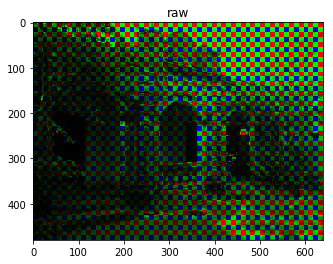

In [6]:
from paddle import nn
import paddle
from collections import OrderedDict
from PIL import Image
import paddle.vision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline


class DJDDNetWork(nn.Layer):
    def __init__(self, width=64, depth=16):
        super(DJDDNetWork, self).__init__()

        self.width = width
        self.depth = depth

        # downsampling
        self.down_sample = nn.Conv2D(3, 4, kernel_size=2, stride=2, padding=0)
  
        # mian layers
        self.main_layers = nn.Sequential(
            ("Conv_1", nn.Conv2D(4, 64, kernel_size=3, padding="SAME")),
            ("ReLu_1", nn.ReLU()),
        )
        for i in range(1, depth - 1):
            in_size = width
            out_size = width
            self.main_layers.add_sublayer("Conv_{}".format(i+1), nn.Conv2D(in_size, out_size, kernel_size=3, padding="SAME"))
            self.main_layers.add_sublayer("ReLu_{}".format(i+1), nn.ReLU())
        
        # residual
        self.residual = nn.Conv2D(width, 12, (1, 1))

        # upsample
        self.up_sample = nn.Conv2DTranspose(12, 3, (2, 2), stride=(2, 2))

        # final processing
        self.final_process = nn.Sequential(
            nn.Conv2D(6, width, 3, padding="SAME"),
            nn.ReLU(),
            nn.Conv2D(width, 3, 1, padding="SAME")
        )


    def forward(self, inputs):
        y = self.down_sample(inputs)
        y = self.main_layers(y)
        y = self.residual(y)
        y = self.up_sample(y)
        y = paddle.concat(x=[inputs, y], axis=1)
        y = self.final_process(y)
        return y


raw = Image.open("/home/aistudio/djddData/Validations/samples/00012_raw.png")
plt.figure()
plt.imshow(raw)
plt.title("raw")
plt.show()


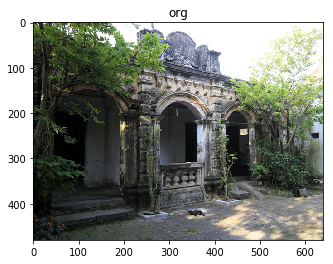

In [8]:
org = Image.open("/home/aistudio/djddData/Validations/labels/00012.jpg")
plt.figure()
plt.imshow(org)
plt.title("org")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


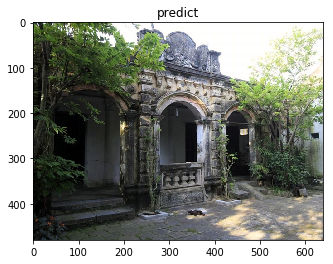

In [16]:
transform = T.ToTensor()
tensor_img = transform(raw).reshape([1, 3, 480, 640])

# 创建模型并导入参数
model = DJDDNetWork()
opt = paddle.optimizer.Adam(parameters=model.parameters())
loss_func = paddle.nn.MSELoss()

model_state_dict = paddle.load("/home/aistudio/DJDD.pdparams")
opt_state_dict = paddle.load("/home/aistudio/adam.pdopt")

model.set_state_dict(model_state_dict)
opt.set_state_dict(opt_state_dict)

model.eval()
output = model(tensor_img).reshape([3, 480, 640])
predict = paddle.transpose(output, perm=[1, 2, 0])

plt.figure()
plt.imshow(predict)
plt.title("predict")
plt.show()
